# Использвание признаков изображений 
Заполните этот блокнот, выполните код и защитите результаты. Полностью заполненный блокнот необходимо сохранить в электронном виде, передав его копию преподавателю, ведущему занятия. 

Мы видели, что мы можем достичь обоснованной эффективности решения задачи классификации изображений путем обучения линейного классификатора, используя пиксели входного изображения. В этом задании мы повысим эффективность классификации  путем обучения линейных классификаторов не на исходным пикселях, а на основе признаков, которые вычисляются в ходе анализа изображений.

Все решения этого задания будут выполняться непосредственно в этом блокноте.

In [1]:
from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # установка размеров графиков по умолчанию
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# для перезагрузки внешних модули python;
# см. http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Загрузка данных

Аналочно предыдущим заданиям, загрузим базу CIFAF-10 c диска.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # выборка данных
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Очистка переменных для предотвращения повторной загрузки данных
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Извлечение признаков

Для каждого изображения будем вычислять гистограмму ориентированных градиентов (HOG), а также гистограмму цветов (HOC) с использованием шкалы оттенков цветового пространства HSV. Конечный вектор признаков для каждого изображения формируется путем конкатенации векторов гистограмм HOG и HOC.

Приближенно, HOG  фиксирует текстуру изображения, игнорируя цветовую информацию, а гистограмма цветов фиксирует рапределение цветов изображения при игнорировании текстуры. В результате мы ожидаем, что совместное использование 2-х гистограмм должно работать лучше. Проверка этого предположения и есть цель этого задания.

Функции `hog_feature` и` color_histogram_hsv` работают с одним и тем же
изображением и возвращают вектор признаков для этого изображения. Функция `extract_features`
вопринимает множество изображений и список признаковых функций и применяет каждую функцию  к изображению, сохраняя результаты в матрице, где каждый столбец является конкатенацией всех векторов признаков для одного изображения.

In [3]:
from cs231n.features import *

num_color_bins = 10 # число столбцов гистограммы НОС
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Предобработка: Вычитание среднего признака
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Предобработка: Деление на стандартное отклонеине. Это обеспечивает для каждого признака
# примерно один и тот же масштаб.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Предобработка: Разширение размера для добавления смещения
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Обучение SVM классификатора на признаках изображений

Используя многоклассовый SVM классификатор, разработанный ранее, обучите его с использованием признаков извлеченных из изображений выше; результаты классификации должны быть лучше, чем  при обучении SVM непосредственно с использованием пикселей изображений.

In [4]:
# Используйте валидационное множество для выбора скорости обучения и коэффициента регуляризации
from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [1e5, 1e6, 1e7]

results = {}
best_val = -1
best_svm = None

################################################################################
# ЗАДАНИЕ:                                                                     #
# Используйте валидационное множество для выбора скорости обучения и           #
# коэффициента регуляризации. Это аналогично валидации, которую вы делали      #
# для SVM классификатора; сохраните наилучший классификатор  в best_svm.       #
# Вы также можете варьировать число столбцов гистограммы цветов. При           # 
# тщательном обучении вы должны получить валидацинную точность около 0.44.     #
################################################################################

def compute_accuracy(y, y_pred):
    return np.mean(y == y_pred)

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=10000, verbose=False)
        train_accuracy = compute_accuracy(y_train, svm.predict(X_train_feats))
        val_accuracy = compute_accuracy(y_val, svm.predict(X_val_feats))
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
#################################
################################################################################
#                              КОНЕЦ ВАШЕГО КОДА                               #
################################################################################

# Вывод результатов.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 1.000000e+05 train accuracy: 0.088571 val accuracy: 0.092000
lr 1.000000e-09 reg 1.000000e+06 train accuracy: 0.415633 val accuracy: 0.418000
lr 1.000000e-09 reg 1.000000e+07 train accuracy: 0.412959 val accuracy: 0.423000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.415898 val accuracy: 0.426000
lr 1.000000e-08 reg 1.000000e+06 train accuracy: 0.411673 val accuracy: 0.415000
lr 1.000000e-08 reg 1.000000e+07 train accuracy: 0.407265 val accuracy: 0.404000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.415245 val accuracy: 0.425000
lr 1.000000e-07 reg 1.000000e+06 train accuracy: 0.402918 val accuracy: 0.396000
lr 1.000000e-07 reg 1.000000e+07 train accuracy: 0.275776 val accuracy: 0.300000
best validation accuracy achieved during cross-validation: 0.426000


In [7]:
# Проверка обученного классификатора на тестовом множесте
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.422


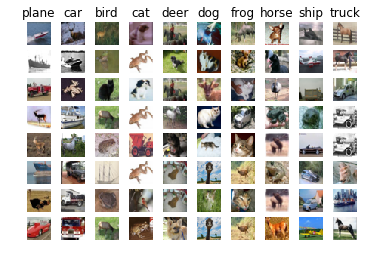

In [6]:
# Важным способом развития интуиции в отношении понимания работы алгоритма является
# визуализуализация ошибок, которые он совершает. Визуализация ниже демонстрирует примеры
# изображений, которые неправильно классифицируются текущей версией программы. Первый столбец
# показывает изображения, которым программа  присвоила метку «самолет», но чьи настоящие метки
# таковыми не являются.

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=True)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Вопрос 1:

Опишите результаты ошибочной классификации, которые Вы наблюдаете. Они имеют обоснование?
Связано с выбором признакового пространства.

Кажется, у каждого класса похожие цвета или цветовая гамма. Например изображения "самолет" голубоватого оттенка.
Возможно это связанно с признаком гистограммы или формой/тексторой(признаки HOG).
Формы также соответствуют классу. Например, «собаки» имеют более округлые формы, а «грузовики» или «корабли» острее.

## Обучение нейросети на признаках изображений
 
Ранее Вы видели, что  двухслойная нейронная сеть, обучаемая  непосредственно на пикселях изображения, обеспечивала более высокую точность классификации, чем линейные классификаторы. Выше Вы также установили, что линейные классификаторы, обучаемые на  признаках изображений, превосходят линейные классификаторы, обучаемые на "сырых" пикселях.

Для полноты исследований необходимо обучить нейронную сеть на признаках изображений. Такая сеть  должна дать лучшие результаты: вы должны легко получить точность классификации более 55%  на тестовом множестве; наша лучшая модель обладала  точностью  классификации около 60% 

In [24]:
# Предобработка: Удаление измерения смещения
# Эта ячейка блокнота должна выполняться только один  раз!
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [ ]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = [500,1000,1500]
num_classes = 10

best_net = None

################################################################################
# ЗАДАНИЕ: Обучите 2-х слойную нейросеть на признаках изображений. Выполните   #
# кросс-валидацию различных парметров, аналогично предыдущим разделам.         #
# Сохраните вашу лучшую модель нейросети в переменной best_net.                #            
################################################################################
# Обучение сети
best_val = -1
learning_rates = [0.1,0.5,1.0]
regularization_strengths = [1e-3, 3e-3, 5e-3]

for hidden_size in hidden_dim:
    for lr in learning_rates:
        for reg in regularization_strengths:
          print("------------------------")
          print("hidden size: %d, lr: %.4f, reg: %.5f" %(hidden_size, lr, reg))
          net = TwoLayerNet(input_dim, hidden_size, num_classes)
          stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=3000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=False)
          print("train accuracy: %.4f" %stats["train_acc_history"][-1])
          print("validation accuracy: %.4f" %stats["val_acc_history"][-1])

          if best_val < stats['val_acc_history'][-1]:
            best_val = stats['val_acc_history'][-1]
            best_net = net
            best_stats = stats
         
print('best validation accuracy achieved during cross-validation: %f' % best_val)
################################################################################
#                              КОНЕЦ ВАШЕГО КОДА                               #
################################################################################

------------------------
hidden size: 500, lr: 0.1000, reg: 0.00100
train accuracy: 0.5800
validation accuracy: 0.5520
------------------------
hidden size: 500, lr: 0.1000, reg: 0.00300
train accuracy: 0.5450
validation accuracy: 0.5520
------------------------
hidden size: 500, lr: 0.1000, reg: 0.00500
train accuracy: 0.5500
validation accuracy: 0.5390
------------------------
hidden size: 500, lr: 0.5000, reg: 0.00100
train accuracy: 0.8900
validation accuracy: 0.5720
------------------------
hidden size: 500, lr: 0.5000, reg: 0.00300
train accuracy: 0.8200
validation accuracy: 0.5980
------------------------
hidden size: 500, lr: 0.5000, reg: 0.00500
train accuracy: 0.7400
validation accuracy: 0.5840
------------------------
hidden size: 500, lr: 1.0000, reg: 0.00100
train accuracy: 0.9600
validation accuracy: 0.5770
------------------------
hidden size: 500, lr: 1.0000, reg: 0.00300
train accuracy: 0.8400
validation accuracy: 0.5720
------------------------
hidden size: 500, lr: 1

In [45]:
# Проверьте Вашу лучшую модель на тестовом множестве. Вы должы получить
# точность классификации более 55%

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.585
